## Reading Data and Importing Libraries ##

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score

In [2]:
nrows = 200 * 10000

train = pd.read_csv('riiid_data/train.csv',
                   usecols=[1, 2, 3, 4, 5, 7, 8, 9],
                    nrows = nrows,
                   dtype={'timestamp': 'int64',
                          'user_id': 'int32',
                          'content_id': 'int16',
                          'content_type_id': 'int8',
                          'task_container_id': 'int16',
                          'answered_correctly':'int8',
                          'prior_question_elapsed_time': 'float32',
                          'prior_question_had_explanation': 'boolean'}
                   )

In [3]:
#reading in question df
questions_df = pd.read_csv('riiid_data/questions.csv',   
                            nrows = nrows,
                            usecols=[0, 3],
                            dtype={'question_id': 'int16',
                              'part': 'int8'}
                          )

In [4]:
#reading in lecture df
lectures_df = pd.read_csv('riiid_data/lectures.csv')

In [5]:
lectures_df['type_of'] = lectures_df['type_of'].replace('solving question', 'solving_question')

lectures_df = pd.get_dummies(lectures_df, columns=['part', 'type_of'])

part_lectures_columns = [column for column in lectures_df.columns if column.startswith('part')]

types_of_lectures_columns = [column for column in lectures_df.columns if column.startswith('type_of_')]

In [6]:
lectures_df.head()

,lecture_id,tag,part_1,part_2,part_3,part_4,part_5,part_6,part_7,type_of_concept,type_of_intention,type_of_solving_question,type_of_starter
0,89,159,0,0,0,0,1,0,0,1,0,0,0
1,100,70,1,0,0,0,0,0,0,1,0,0,0
2,185,45,0,0,0,0,0,1,0,1,0,0,0
3,192,79,0,0,0,0,1,0,0,0,0,1,0
4,317,156,0,0,0,0,1,0,0,0,0,1,0


In [7]:
# merge lecture features to train dataset
train_lectures = train[train.content_type_id == True].merge(lectures_df, left_on='content_id', right_on='lecture_id', how='left')

In [8]:
train_lectures.head()

,timestamp,user_id,content_id,content_type_id,task_container_id,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,lecture_id,tag,...,part_2,part_3,part_4,part_5,part_6,part_7,type_of_concept,type_of_intention,type_of_solving_question,type_of_starter
0,653762,2746,6808,1,14,-1,NaN,False,6808,129,...,1,0,0,0,0,0,0,1,0,0
1,10183847,5382,16736,1,21,-1,NaN,False,16736,40,...,0,0,0,0,0,0,1,0,0,0
2,1424348597,5382,30207,1,104,-1,NaN,False,30207,43,...,0,0,0,1,0,0,1,0,0,0
3,1425557777,5382,18545,1,121,-1,NaN,False,18545,58,...,0,0,0,1,0,0,1,0,0,0
4,405813029,8623,10540,1,59,-1,NaN,False,10540,99,...,0,0,0,0,0,0,1,0,0,0


In [9]:
# collect per user stats
user_lecture_stats_part = train_lectures.groupby('user_id')[part_lectures_columns + types_of_lectures_columns].sum()

In [10]:
user_lecture_stats_part.head()

,part_1,part_2,part_3,part_4,part_5,part_6,part_7,type_of_concept,type_of_intention,type_of_solving_question,type_of_starter
user_id,,,,,,,,,,,
2746,0,1,0,0,0,0,0,0,1,0,0
5382,1,0,0,0,2,0,0,3,0,0,0
8623,2,1,0,0,0,0,0,3,0,0,0
12741,0,0,0,3,0,1,2,4,0,2,0
13134,1,3,0,0,3,0,0,6,1,0,0


In [11]:
# add boolean features
for column in user_lecture_stats_part.columns:
    bool_column = column + '_boolean'
    user_lecture_stats_part[bool_column] = (user_lecture_stats_part[column] > 0).astype(int)

In [12]:
user_lecture_stats_part.head()

,part_1,part_2,part_3,part_4,part_5,part_6,part_7,type_of_concept,type_of_intention,type_of_solving_question,...,part_2_boolean,part_3_boolean,part_4_boolean,part_5_boolean,part_6_boolean,part_7_boolean,type_of_concept_boolean,type_of_intention_boolean,type_of_solving_question_boolean,type_of_starter_boolean
user_id,,,,,,,,,,,,,,,,,,,,,
2746,0,1,0,0,0,0,0,0,1,0,...,1,0,0,0,0,0,0,1,0,0
5382,1,0,0,0,2,0,0,3,0,0,...,0,0,0,1,0,0,1,0,0,0
8623,2,1,0,0,0,0,0,3,0,0,...,1,0,0,0,0,0,1,0,0,0
12741,0,0,0,3,0,1,2,4,0,2,...,0,0,1,0,1,1,1,0,1,0
13134,1,3,0,0,3,0,0,6,1,0,...,1,0,0,1,0,0,1,1,0,0


In [13]:
#clearing memory
del(train_lectures)

Affirmatives (True) for content_type_id are only for those with a different type of content (lectures). These are not real questions.

In [14]:
#removing True or 1 for content_type_id

train = train[train.content_type_id == False].sort_values('timestamp').reset_index(drop = True)

In [15]:
train[(train.task_container_id == 9999)].tail()

,timestamp,user_id,content_id,content_type_id,task_container_id,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
1786449,24925609370,39919444,7979,0,9999,1,19000.0,True
1847134,31352567848,40224694,5316,0,9999,1,8000.0,True


In [16]:
train[(train.content_type_id == False)].task_container_id.nunique()

9999

In [17]:
#saving value to fillna
elapsed_mean = train.prior_question_elapsed_time.mean()


In [18]:
group1 = train.loc[(train.content_type_id == False), ['task_container_id', 'user_id']].groupby(['task_container_id']).agg(['count'])
group1.columns = ['avg_questions']
group2 = train.loc[(train.content_type_id == False), ['task_container_id', 'user_id']].groupby(['task_container_id']).agg(['nunique'])
group2.columns = ['avg_questions']
group3 = group1 / group2

In [19]:
group3['avg_questions_seen'] = group3.avg_questions.cumsum()

In [20]:
group3.iloc[0].avg_questions_seen

1.0062272963155163

In [21]:
results_u_final = train.loc[train.content_type_id == False, ['user_id','answered_correctly']].groupby(['user_id']).agg(['mean'])
results_u_final.columns = ['answered_correctly_user']

results_u2_final = train.loc[train.content_type_id == False, ['user_id','prior_question_had_explanation']].groupby(['user_id']).agg(['mean'])
results_u2_final.columns = ['explanation_mean_user']

In [22]:
results_u2_final.explanation_mean_user.describe()

count    7709.000000
mean        0.565149
std         0.360969
min         0.000000
25%         0.230769
50%         0.650000
75%         0.906061
max         1.000000
Name: explanation_mean_user, dtype: float64

In [23]:
train = pd.merge(train, questions_df, left_on = 'content_id', right_on = 'question_id', how = 'left')

In [24]:
results_q_final = train.loc[train.content_type_id == False, ['question_id','answered_correctly']].groupby(['question_id']).agg(['mean'])
results_q_final.columns = ['quest_pct']

In [25]:
results_q2_final = train.loc[train.content_type_id == False, ['question_id','part']].groupby(['question_id']).agg(['count'])
results_q2_final.columns = ['count']

In [26]:
question2 = pd.merge(questions_df, results_q_final, left_on = 'question_id', right_on = 'question_id', how = 'left')

In [27]:
question2 = pd.merge(question2, results_q2_final, left_on = 'question_id', right_on = 'question_id', how = 'left')

In [28]:
question2.quest_pct = round(question2.quest_pct,5)

In [29]:
display(question2.head(), question2.tail())

,question_id,part,quest_pct,count
0,0,1,0.89474,152.0
1,1,1,0.92667,150.0
2,2,1,0.55386,919.0
3,3,1,0.79452,438.0
4,4,1,0.64154,650.0


,question_id,part,quest_pct,count
13518,13518,5,0.76471,17.0
13519,13519,5,0.47059,17.0
13520,13520,5,0.70588,17.0
13521,13521,5,0.66667,21.0
13522,13522,5,0.82353,17.0


In [30]:
train.head()

,timestamp,user_id,content_id,content_type_id,task_container_id,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,question_id,part
0,0,115,5692,0,1,1,NaN,<NA>,5692,5
1,0,39068636,7900,0,0,1,NaN,<NA>,7900,1
2,0,2121898,5556,0,0,1,NaN,<NA>,5556,5
3,0,11460655,128,0,0,1,NaN,<NA>,128,1
4,0,11459815,7900,0,0,1,NaN,<NA>,7900,1


In [31]:
len(train)

1961017

## Data Exploration ##

In [32]:
len(train)

1961017

In [33]:
train.answered_correctly.mean()

0.6544859121568044

In [34]:
prior_mean_user = results_u2_final.explanation_mean_user.mean()

In [35]:
train.loc[(train.timestamp == 0)].answered_correctly.mean()

0.6812790097988654

In [36]:
train.loc[(train.timestamp != 0)].answered_correctly.mean()

0.654379522245107

In [37]:
train.drop(['timestamp', 'content_type_id', 'question_id', 'part'], axis=1, inplace=True)

In [38]:
len(train)

1961017

## Creating Validation Set (Most Recent Answers by User) ##

In [39]:
validation = train.groupby('user_id').tail(5)
train = train[~train.index.isin(validation.index)]
len(train) + len(validation)

1961017

In [40]:
validation.answered_correctly.mean()

0.5400544959128065

In [41]:
train.answered_correctly.mean()

0.6567796213436589

In [42]:
results_u_val = train[['user_id','answered_correctly']].groupby(['user_id']).agg(['mean'])
results_u_val.columns = ['answered_correctly_user']

results_u2_val = train[['user_id','prior_question_had_explanation']].groupby(['user_id']).agg(['mean'])
results_u2_val.columns = ['explanation_mean_user']

Does it make sense to use last questions as validation? Why is the rate of correct answers so low?
I am convinced there is a better way to match the test data.

## Extracting Training Data ##

In [43]:
X = train.groupby('user_id').tail(18)
train = train[~train.index.isin(X.index)]
len(X) + len(train) + len(validation)

1961017

In [44]:
X.answered_correctly.mean()

0.5514405200868873

In [45]:
train.answered_correctly.mean()

0.6643792185571621

In [46]:
results_u_X = train[['user_id','answered_correctly']].groupby(['user_id']).agg(['mean'])
results_u_X.columns = ['answered_correctly_user']

results_u2_X = train[['user_id','prior_question_had_explanation']].groupby(['user_id']).agg(['mean'])
results_u2_X.columns = ['explanation_mean_user']

## Merging Data ##

In [47]:
#clearing memory
del(train)

In [48]:
X = pd.merge(X, group3, left_on=['task_container_id'], right_index= True, how="left")
X = pd.merge(X, results_u_X, on=['user_id'], how="left")
X = pd.merge(X, results_u2_X, on=['user_id'], how="left")

X = pd.merge(X, user_lecture_stats_part, on=['user_id'], how="left")

In [49]:
validation = pd.merge(validation, group3, left_on=['task_container_id'], right_index= True, how="left")
validation = pd.merge(validation, results_u_val, on=['user_id'], how="left")
validation = pd.merge(validation, results_u2_val, on=['user_id'], how="left")

validation = pd.merge(validation, user_lecture_stats_part, on=['user_id'], how="left")

In [50]:
from sklearn.preprocessing import LabelEncoder

lb_make = LabelEncoder()

X.prior_question_had_explanation.fillna(False, inplace = True)
validation.prior_question_had_explanation.fillna(False, inplace = True)

validation["prior_question_had_explanation_enc"] = lb_make.fit_transform(validation["prior_question_had_explanation"])
X["prior_question_had_explanation_enc"] = lb_make.fit_transform(X["prior_question_had_explanation"])

In [51]:
#reading in question df
#question2 = pd.read_csv('/kaggle/input/question2/question2.csv)

In [52]:
content_mean = question2.quest_pct.mean()

question2.quest_pct.mean()
#there are a lot of high percentage questions, should use median instead?

0.7022135696126812

In [53]:
#filling questions with no info with a new value
question2.quest_pct = question2.quest_pct.mask((question2['count'] < 3), .65)


#filling very hard new questions with a more reasonable value
question2.quest_pct = question2.quest_pct.mask((question2.quest_pct < .2) & (question2['count'] < 21), .2)

#filling very easy new questions with a more reasonable value
question2.quest_pct = question2.quest_pct.mask((question2.quest_pct > .95) & (question2['count'] < 21), .95)

In [54]:
X = pd.merge(X, question2, left_on = 'content_id', right_on = 'question_id', how = 'left')
validation = pd.merge(validation, question2, left_on = 'content_id', right_on = 'question_id', how = 'left')
X.part = X.part - 1
validation.part = validation.part - 1

In [55]:
X.head()

,user_id,content_id,task_container_id,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,avg_questions,avg_questions_seen,answered_correctly_user,explanation_mean_user,...,part_7_boolean,type_of_concept_boolean,type_of_intention_boolean,type_of_solving_question_boolean,type_of_starter_boolean,prior_question_had_explanation_enc,question_id,part,quest_pct,count
0,11450549,7900,0,1,NaN,False,1.006227,1.006227,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0,7900,0,0.81484,3559.0
1,27474736,4850,0,1,NaN,False,1.006227,1.006227,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0,4850,4,0.45679,81.0
2,27399024,4133,0,1,NaN,False,1.006227,1.006227,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0,4133,4,0.74815,135.0
3,27420468,5299,0,1,NaN,False,1.006227,1.006227,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0,5299,4,0.49074,216.0
4,19539567,5991,0,0,NaN,False,1.006227,1.006227,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0,5991,4,0.83938,193.0


In [56]:
y = X['answered_correctly']
X = X.drop(['answered_correctly'], axis=1)
X.head()

y_val = validation['answered_correctly']
X_val = validation.drop(['answered_correctly'], axis=1)

In [57]:

X = X[['answered_correctly_user', 'explanation_mean_user', 'quest_pct', 'avg_questions_seen',
       'prior_question_elapsed_time','prior_question_had_explanation_enc', 'part',
       'part_1', 'part_2', 'part_3', 'part_4', 'part_5', 'part_6', 'part_7',
       'type_of_concept', 'type_of_intention', 'type_of_solving_question', 'type_of_starter',
       'part_1_boolean', 'part_2_boolean', 'part_3_boolean', 'part_4_boolean', 'part_5_boolean', 'part_6_boolean', 'part_7_boolean',
       'type_of_concept_boolean', 'type_of_intention_boolean', 'type_of_solving_question_boolean', 'type_of_starter_boolean']]
X_val = X_val[['answered_correctly_user', 'explanation_mean_user', 'quest_pct', 'avg_questions_seen',
               'prior_question_elapsed_time','prior_question_had_explanation_enc', 'part',
               'part_1', 'part_2', 'part_3', 'part_4', 'part_5', 'part_6', 'part_7',
               'type_of_concept', 'type_of_intention', 'type_of_solving_question', 'type_of_starter',
               'part_1_boolean', 'part_2_boolean', 'part_3_boolean', 'part_4_boolean', 'part_5_boolean', 'part_6_boolean', 'part_7_boolean',
               'type_of_concept_boolean', 'type_of_intention_boolean', 'type_of_solving_question_boolean', 'type_of_starter_boolean']]

'''
X = X[['answered_correctly_user', 'explanation_mean_user', 'quest_pct', 'avg_questions_seen',
       'prior_question_elapsed_time','prior_question_had_explanation_enc', 'part',
       'part_1', 'part_2', 'part_3', 'part_4', 'part_5', 'part_6', 'part_7',
       'type_of_concept', 'type_of_intention', 'type_of_solving_question', 'type_of_starter',
       'type_of_concept_boolean', 'type_of_intention_boolean', 'type_of_solving_question_boolean', 'type_of_starter_boolean']]
X_val = X_val[['answered_correctly_user', 'explanation_mean_user', 'quest_pct', 'avg_questions_seen',
               'prior_question_elapsed_time','prior_question_had_explanation_enc', 'part',
               'part_1', 'part_2', 'part_3', 'part_4', 'part_5', 'part_6', 'part_7',
               'type_of_concept', 'type_of_intention', 'type_of_solving_question', 'type_of_starter',
               'type_of_concept_boolean', 'type_of_intention_boolean', 'type_of_solving_question_boolean', 'type_of_starter_boolean']]
'''

"\nX = X[['answered_correctly_user', 'explanation_mean_user', 'quest_pct', 'avg_questions_seen',\n       'prior_question_elapsed_time','prior_question_had_explanation_enc', 'part',\n       'part_1', 'part_2', 'part_3', 'part_4', 'part_5', 'part_6', 'part_7',\n       'type_of_concept', 'type_of_intention', 'type_of_solving_question', 'type_of_starter',\n       'type_of_concept_boolean', 'type_of_intention_boolean', 'type_of_solving_question_boolean', 'type_of_starter_boolean']]\nX_val = X_val[['answered_correctly_user', 'explanation_mean_user', 'quest_pct', 'avg_questions_seen',\n               'prior_question_elapsed_time','prior_question_had_explanation_enc', 'part',\n               'part_1', 'part_2', 'part_3', 'part_4', 'part_5', 'part_6', 'part_7',\n               'type_of_concept', 'type_of_intention', 'type_of_solving_question', 'type_of_starter',\n               'type_of_concept_boolean', 'type_of_intention_boolean', 'type_of_solving_question_boolean', 'type_of_starter_boolean']

In [58]:

# Filling with 0.5 for simplicity; there could likely be a better value
X['answered_correctly_user'].fillna(0.65,  inplace=True)
X['explanation_mean_user'].fillna(prior_mean_user,  inplace=True)
X['quest_pct'].fillna(content_mean, inplace=True)

X['part'].fillna(4, inplace = True)
X['avg_questions_seen'].fillna(1, inplace = True)
X['prior_question_elapsed_time'].fillna(elapsed_mean, inplace = True)
X['prior_question_had_explanation_enc'].fillna(0, inplace = True)

X['part_1'].fillna(0, inplace = True)
X['part_2'].fillna(0, inplace = True)
X['part_3'].fillna(0, inplace = True)
X['part_4'].fillna(0, inplace = True)
X['part_5'].fillna(0, inplace = True)
X['part_6'].fillna(0, inplace = True)
X['part_7'].fillna(0, inplace = True)
X['type_of_concept'].fillna(0, inplace = True)
X['type_of_intention'].fillna(0, inplace = True)
X['type_of_solving_question'].fillna(0, inplace = True)
X['type_of_starter'].fillna(0, inplace = True)
X['part_1_boolean'].fillna(0, inplace = True)
X['part_2_boolean'].fillna(0, inplace = True)
X['part_3_boolean'].fillna(0, inplace = True)
X['part_4_boolean'].fillna(0, inplace = True)
X['part_5_boolean'].fillna(0, inplace = True)
X['part_6_boolean'].fillna(0, inplace = True)
X['part_7_boolean'].fillna(0, inplace = True)
X['type_of_concept_boolean'].fillna(0, inplace = True)
X['type_of_intention_boolean'].fillna(0, inplace = True)
X['type_of_solving_question_boolean'].fillna(0, inplace = True)
X['type_of_starter_boolean'].fillna(0, inplace = True)

In [59]:
X_val['answered_correctly_user'].fillna(0.65,  inplace=True)
X_val['explanation_mean_user'].fillna(prior_mean_user,  inplace=True)
X_val['quest_pct'].fillna(content_mean,  inplace=True)

X_val['part'].fillna(4, inplace = True)
X_val['avg_questions_seen'].fillna(1, inplace = True)
X_val['prior_question_elapsed_time'].fillna(elapsed_mean, inplace = True)
X_val['prior_question_had_explanation_enc'].fillna(0, inplace = True)

X_val['part_1'].fillna(0, inplace = True)
X_val['part_2'].fillna(0, inplace = True)
X_val['part_3'].fillna(0, inplace = True)
X_val['part_4'].fillna(0, inplace = True)
X_val['part_5'].fillna(0, inplace = True)
X_val['part_6'].fillna(0, inplace = True)
X_val['part_7'].fillna(0, inplace = True)
X_val['type_of_concept'].fillna(0, inplace = True)
X_val['type_of_intention'].fillna(0, inplace = True)
X_val['type_of_solving_question'].fillna(0, inplace = True)
X_val['type_of_starter'].fillna(0, inplace = True)
X_val['part_1_boolean'].fillna(0, inplace = True)
X_val['part_2_boolean'].fillna(0, inplace = True)
X_val['part_3_boolean'].fillna(0, inplace = True)
X_val['part_4_boolean'].fillna(0, inplace = True)
X_val['part_5_boolean'].fillna(0, inplace = True)
X_val['part_6_boolean'].fillna(0, inplace = True)
X_val['part_7_boolean'].fillna(0, inplace = True)
X_val['type_of_concept_boolean'].fillna(0, inplace = True)
X_val['type_of_intention_boolean'].fillna(0, inplace = True)
X_val['type_of_solving_question_boolean'].fillna(0, inplace = True)
X_val['type_of_starter_boolean'].fillna(0, inplace = True)

## Modeling ##

In [60]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
X = scaler.fit_transform(X)
X_val = scaler.transform(X_val)
X_train = X.reshape(X.shape[0], X.shape[1])
X_test = X_val.reshape(X_val.shape[0], X_val.shape[1])

In [61]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as Data
from sklearn.metrics import *
from torch.utils.data import DataLoader
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import BatchNormalization,Dropout,Dense,Flatten,Conv1D
from tensorflow.keras.optimizers import Adam
from tensorflow import keras
from tensorflow.keras import layers
import time

try:
    from tensorflow.python.keras.callbacks import CallbackList
except ImportError:
    from tensorflow.python.keras._impl.keras.callbacks import CallbackList
    
class BaseModel(nn.Module):
    def __init__(self, device='cpu'):
        super(BaseModel, self).__init__()
        
        # device
        self.device = device 
        self.regularization_weight = []
        self.to(device)
    
    def compile(self, optimizer,
                loss=None,
                metrics=None,
                ):
        """
        :param optimizer: String (name of optimizer) or optimizer instance. See [optimizers](https://pytorch.org/docs/stable/optim.html).
        :param loss: String (name of objective function) or objective function. See [losses](https://pytorch.org/docs/stable/nn.functional.html#loss-functions).
        :param metrics: List of metrics to be evaluated by the model during training and testing. Typically you will use `metrics=['accuracy']`.
        """
        self.metrics_names = ["loss"]
        self.optim = self._get_optim(optimizer)
        self.loss_func = self._get_loss_func(loss)
        self.metrics = self._get_metrics(metrics)

    def _get_optim(self, optimizer):
        if isinstance(optimizer, str):
            if optimizer == "sgd":
                optim = torch.optim.SGD(self.parameters(), lr=0.01)
            elif optimizer == "adam":
                optim = torch.optim.Adam(self.parameters())  # 0.001
            elif optimizer == "adagrad":
                optim = torch.optim.Adagrad(self.parameters())  # 0.01
            elif optimizer == "rmsprop":
                optim = torch.optim.RMSprop(self.parameters())
            else:
                raise NotImplementedError
        else:
            optim = optimizer
        return optim

    def _get_loss_func(self, loss):
        if isinstance(loss, str):
            if loss == "binary_crossentropy":
                loss_func = F.binary_cross_entropy
            elif loss == "mse":
                loss_func = F.mse_loss
            elif loss == "mae":
                loss_func = F.l1_loss
            else:
                raise NotImplementedError
        else:
            loss_func = loss
        return loss_func

    def _log_loss(self, y_true, y_pred, eps=1e-7, normalize=True, sample_weight=None, labels=None):
        # change eps to improve calculation accuracy
        return log_loss(y_true,
                        y_pred,
                        eps,
                        normalize,
                        sample_weight,
                        labels)

    def _get_metrics(self, metrics, set_eps=False):
        metrics_ = {}
        if metrics:
            for metric in metrics:
                if metric == "binary_crossentropy" or metric == "logloss":
                    if set_eps:
                        metrics_[metric] = self._log_loss
                    else:
                        metrics_[metric] = log_loss
                if metric == "auc":
                    metrics_[metric] = roc_auc_score
                if metric == "mse":
                    metrics_[metric] = mean_squared_error
                if metric == "accuracy" or metric == "acc":
                    metrics_[metric] = lambda y_true, y_pred: accuracy_score(
                        y_true, np.where(y_pred > 0.5, 1, 0))
                self.metrics_names.append(metric)
        return metrics_
    
    def fit(self, x = None, y = None, batch_size=None, epochs=1, verbose=2,  validation_split=0.1, shuffle=True, callbacks=None):
        
        if validation_split and 0. < validation_split < 1.:
            do_validation = True
            
            split_at = int(x.shape[0] * (1. - validation_split))
                
            x_, val_x = x[0:split_at], x[split_at: -1]
            
            y_, val_y = y[0:split_at], y[split_at: -1]
            
            x = x_
            y = y_
        else:
            do_validation = False
            val_x = []
            val_y = []
        
        train_tensor_data = Data.TensorDataset(torch.from_numpy(x), torch.from_numpy(y))
        
        if batch_size is None:
            batch_size = 256
            
        train_loader = DataLoader(
            dataset=train_tensor_data, shuffle=shuffle, batch_size=batch_size)
        
        print(self.device, end="\n")
        model = self.train()
        loss_func = self.loss_func
        optim = self.optim
        
        sample_num = len(train_tensor_data)
        steps_per_epoch = (sample_num - 1) // batch_size + 1

        callbacks = CallbackList(callbacks)
        callbacks.set_model(self)
        callbacks.on_train_begin()
        self.stop_training = False  # used for early stopping

        # Train
        print("Train on {0} samples, validate on {1} samples, {2} steps per epoch".format(
            len(train_tensor_data), len(val_y), steps_per_epoch))
        
        for epoch in range(epochs):
            callbacks.on_epoch_begin(epoch)
            epoch_logs = {}
            start_time = time.time()
            loss_epoch = 0
            total_loss_epoch = 0
            train_result = {}
            try:
                with tqdm(enumerate(train_loader), disable = verbose != 1) as t:
                    for index, (x_train, y_train) in t:
                        x = x_train.to(self.device).float()
                        y = y_train.to(self.device).float()

                        y_pred = model(x).squeeze()
                        #---------------------------
                        #print(y_pred.shape)
                        
                        optim.zero_grad()
                        loss = loss_func(y_pred, y.squeeze(), reduction='sum')
                        
                        #reg_loss = self.get_regularization_loss()

                        #total_loss = loss + reg_loss + self.aux_loss
                        total_loss = loss
                        
                        loss_epoch += loss.item()
                        total_loss_epoch += total_loss.item()
                        total_loss.backward(retain_graph=True)
                        
                        optim.step()

                        if verbose > 0:
                            for name, metric_fun in self.metrics.items():
                                if name not in train_result:
                                    train_result[name] = []
                                train_result[name].append(metric_fun(
                                    y.cpu().data.numpy(), y_pred.cpu().data.numpy().astype("float64")))

            except KeyboardInterrupt:
                t.close()
                raise
            t.close()

            # Add epoch_logs
            epoch_logs["loss"] = total_loss_epoch / sample_num
            for name, result in train_result.items():
                epoch_logs[name] = np.sum(result) / steps_per_epoch

            if do_validation:
                eval_result = self.evaluate(val_x, val_y, batch_size)
                for name, result in eval_result.items():
                    epoch_logs["val_" + name] = result
                    
            # verbose
            if verbose > 0:
                epoch_time = int(time.time() - start_time)
                print('Epoch {0}/{1}'.format(epoch + 1, epochs))

                eval_str = "{0}s - loss: {1: .4f}".format(
                    epoch_time, epoch_logs["loss"])

                for name in self.metrics:
                    eval_str += " - " + name + \
                                ": {0: .4f}".format(epoch_logs[name])

                if do_validation:
                    for name in self.metrics:
                        eval_str += " - " + "val_" + name + \
                                    ": {0: .4f}".format(epoch_logs["val_" + name])
                print(eval_str)
            callbacks.on_epoch_end(epoch, epoch_logs)
            if self.stop_training:
                break

        callbacks.on_train_end()
        
    def evaluate(self, x, y, batch_size=256):
        """

        :param x: Numpy array of test data (if the model has a single input), or list of Numpy arrays (if the model has multiple inputs).
        :param y: Numpy array of target (label) data (if the model has a single output), or list of Numpy arrays (if the model has multiple outputs).
        :param batch_size: Integer or `None`. Number of samples per evaluation step. If unspecified, `batch_size` will default to 256.
        :return: Dict contains metric names and metric values.
        """
        pred_ans = self.predict(x, batch_size)
        eval_result = {}
        for name, metric_fun in self.metrics.items():
            eval_result[name] = metric_fun(y, pred_ans)
        return eval_result

    def predict(self, x, batch_size=256):
        """

        :param x: The input data, as a Numpy array (or list of Numpy arrays if the model has multiple inputs).
        :param batch_size: Integer. If unspecified, it will default to 256.
        :return: Numpy array(s) of predictions.
        """
        model = self.eval()
        tensor_data = Data.TensorDataset(torch.tensor(x))
        test_loader = DataLoader(
            dataset=tensor_data, shuffle=False, batch_size=batch_size)

        pred_ans = []
        with torch.no_grad():
            for index, x_test in enumerate(test_loader):
                x = x_test[0].to(self.device).float()

                y_pred = model(x).cpu().data.numpy()  # .squeeze()
                pred_ans.append(y_pred)

        return np.concatenate(pred_ans).astype("float64")
    
    def add_regularization_weight(self, weight_list, weight_decay, p=2):
        self.regularization_weight.append((list(weight_list), weight_decay, p))

    def get_regularization_loss(self, ):
        total_reg_loss = torch.zeros((1,), device=self.device)
        for weight_list, weight_decay, p in self.regularization_weight:
            weight_reg_loss = torch.zeros((1,), device=self.device)
            for w in weight_list:
                if isinstance(w, tuple):
                    l2_reg = torch.norm(w[1], p=p, )
                else:
                    l2_reg = torch.norm(w, p=p, )
                weight_reg_loss = weight_reg_loss + l2_reg
            reg_loss = weight_decay * weight_reg_loss
            total_reg_loss += reg_loss
        return total_reg_loss

    
def activation_layer(act_name, hidden_size=None, dice_dim=2):
    """Construct activation layers

    Args:
        act_name: str or nn.Module, name of activation function
        hidden_size: int, used for Dice activation
        dice_dim: int, used for Dice activation
    Return:
        act_layer: activation layer
    """
    if isinstance(act_name, str):
        if act_name.lower() == 'sigmoid':
            act_layer = nn.Sigmoid()
        elif act_name.lower() == 'linear':
            act_layer = Identity()
        elif act_name.lower() == 'relu':
            act_layer = nn.ReLU(inplace=True)
        elif act_name.lower() == 'dice':
            assert dice_dim
            act_layer = Dice(hidden_size, dice_dim)
        elif act_name.lower() == 'prelu':
            act_layer = nn.PReLU()
    elif issubclass(act_name, nn.Module):
        act_layer = act_name()
    else:
        raise NotImplementedError

    return act_layer

    
    
class PredictionLayer(nn.Module):
    """
      Arguments
         - **task**: str, ``"binary"`` for  binary logloss or  ``"regression"`` for regression loss
         - **use_bias**: bool.Whether add bias term or not.
    """

    def __init__(self, task='binary', use_bias=True, **kwargs):
        if task not in ["binary", "multiclass", "regression"]:
            raise ValueError("task must be binary,multiclass or regression")

        super(PredictionLayer, self).__init__()
        self.use_bias = use_bias
        self.task = task
        if self.use_bias:
            self.bias = nn.Parameter(torch.zeros((1,)))
        self.to('cuda:0')
    def forward(self, X):
        output = X
        if self.use_bias:
            output += self.bias
        if self.task == "binary":
            output = torch.sigmoid(output)
        return output


class TokenAndPositionEmbedding(nn.Module):
    def __init__(self, maxlen = 32, vocab_size = 50000, embed_dim = 32, device = 'cpu'):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = nn.Embedding(num_embeddings  = vocab_size, embedding_dim  = embed_dim)   
        nn.init.normal_(self.token_emb.weight, mean=0, std=0.0001)
        
        self.to(device)
    
    # 这里默认输入的是tensor
    def forward(self, x):
        
        return self.token_emb(x)
    
    
class Linear(nn.Module):
    def __init__(self, device = 'cpu'):
        super(Linear, self).__init__()
        self.embedding_layer = TokenAndPositionEmbedding(vocab_size  = 50000, embed_dim  = 32)    
        self.to(device)
        
    def forward(self, x):
        linear_sparse_logit = torch.sum(
                torch.flatten(x,start_dim=1), dim=-1, keepdim=True)
        
        return linear_sparse_logit


class DNN(nn.Module):
    """The Multi Layer Percetron

      Input shape
        - nD tensor with shape: ``(batch_size, ..., input_dim)``. The most common situation would be a 2D input with shape ``(batch_size, input_dim)``.

      Output shape
        - nD tensor with shape: ``(batch_size, ..., hidden_size[-1])``. For instance, for a 2D input with shape ``(batch_size, input_dim)``, the output would have shape ``(batch_size, hidden_size[-1])``.

      Arguments
        - **inputs_dim**: input feature dimension.

        - **hidden_units**:list of positive integer, the layer number and units in each layer.

        - **activation**: Activation function to use.

        - **l2_reg**: float between 0 and 1. L2 regularizer strength applied to the kernel weights matrix.

        - **dropout_rate**: float in [0,1). Fraction of the units to dropout.

        - **use_bn**: bool. Whether use BatchNormalization before activation or not.

        - **seed**: A Python integer to use as random seed.
    """

    def __init__(self, inputs_dim, hidden_units, activation='relu', l2_reg=0, dropout_rate=0.5, use_bn=True,
                 init_std=0.0001, dice_dim=3, seed=1024, device='cpu'):
        super(DNN, self).__init__()
        self.dropout_rate = dropout_rate
        self.dropout = nn.Dropout(dropout_rate)
        self.seed = seed
        self.l2_reg = l2_reg
        self.use_bn = use_bn
        if len(hidden_units) == 0:
            raise ValueError("hidden_units is empty!!")
        hidden_units = [inputs_dim] + list(hidden_units)

        self.linears = nn.ModuleList(
            [nn.Linear(hidden_units[i], hidden_units[i + 1]) for i in range(len(hidden_units) - 1)])

        if self.use_bn:
            self.bn = nn.ModuleList(
                [nn.BatchNorm1d(hidden_units[i + 1]) for i in range(len(hidden_units) - 1)])

        self.activation_layers = nn.ModuleList(
            [activation_layer(activation, hidden_units[i + 1], dice_dim) for i in range(len(hidden_units) - 1)])

        for name, tensor in self.linears.named_parameters():
            if 'weight' in name:
                nn.init.normal_(tensor, mean=0, std=init_std)

        self.to(device)

    def forward(self, inputs):
        deep_input = inputs

        for i in range(len(self.linears)):

            fc = self.linears[i](deep_input)

            if self.use_bn:
                fc = self.bn[i](fc)

            fc = self.activation_layers[i](fc)

            fc = self.dropout(fc)
            deep_input = fc
        return deep_input
    
    
    

class FM(nn.Module):
    """Factorization Machine models pairwise (order-2) feature interactions
     without linear term and bias.
      Input shape
        - 3D tensor with shape: ``(batch_size,field_size,embedding_size)``.
      Output shape
        - 2D tensor with shape: ``(batch_size, 1)``.
      References
        - [Factorization Machines](https://www.csie.ntu.edu.tw/~b97053/paper/Rendle2010FM.pdf)
    """

    def __init__(self):
        super(FM, self).__init__()

    def forward(self, inputs):
        fm_input = inputs

        square_of_sum = torch.pow(torch.sum(fm_input, dim=1, keepdim=True), 2)
        sum_of_square = torch.sum(fm_input * fm_input, dim=1, keepdim=True)
        cross_term = square_of_sum - sum_of_square
        cross_term = 0.5 * torch.sum(cross_term, dim=2, keepdim=False)

        return cross_term


class CIN(nn.Module):
    """Compressed Interaction Network used in xDeepFM.
      Input shape
        - 3D tensor with shape: ``(batch_size,field_size,embedding_size)``.
      Output shape
        - 2D tensor with shape: ``(batch_size, featuremap_num)`` ``featuremap_num =  sum(self.layer_size[:-1]) // 2 + self.layer_size[-1]`` if ``split_half=True``,else  ``sum(layer_size)`` .
      Arguments
        - **filed_size** : Positive integer, number of feature groups.
        - **layer_size** : list of int.Feature maps in each layer.
        - **activation** : activation function name used on feature maps.
        - **split_half** : bool.if set to False, half of the feature maps in each hidden will connect to output unit.
        - **seed** : A Python integer to use as random seed.
      References
        - [Lian J, Zhou X, Zhang F, et al. xDeepFM: Combining Explicit and Implicit Feature Interactions for Recommender Systems[J]. arXiv preprint arXiv:1803.05170, 2018.] (https://arxiv.org/pdf/1803.05170.pdf)
    """

    def __init__(self, field_size, layer_size=(128, 128), activation='relu', split_half=True, l2_reg=1e-5, seed=1024,
                 device='cpu'):
        super(CIN, self).__init__()
        if len(layer_size) == 0:
            raise ValueError(
                "layer_size must be a list(tuple) of length greater than 1")

        self.layer_size = layer_size
        self.field_nums = [field_size]
        self.split_half = split_half
        self.activation = activation_layer(activation)
        self.l2_reg = l2_reg
        self.seed = seed

        self.conv1ds = nn.ModuleList()
        for i, size in enumerate(self.layer_size):
            self.conv1ds.append(
                nn.Conv1d(self.field_nums[-1] * self.field_nums[0], size, 1))

            if self.split_half:
                if i != len(self.layer_size) - 1 and size % 2 > 0:
                    raise ValueError(
                        "layer_size must be even number except for the last layer when split_half=True")

                self.field_nums.append(size // 2)
            else:
                self.field_nums.append(size)

        #         for tensor in self.conv1ds:
        #             nn.init.normal_(tensor.weight, mean=0, std=init_std)
        self.to(device)

    def forward(self, inputs):
        if len(inputs.shape) != 3:
            raise ValueError(
                "Unexpected inputs dimensions %d, expect to be 3 dimensions" % (len(inputs.shape)))
        batch_size = inputs.shape[0]
        dim = inputs.shape[-1]
        hidden_nn_layers = [inputs]
        final_result = []

        for i, size in enumerate(self.layer_size):
            # x^(k-1) * x^0
            x = torch.einsum(
                'bhd,bmd->bhmd', hidden_nn_layers[-1], hidden_nn_layers[0])
            # x.shape = (batch_size , hi * m, dim)
            x = x.reshape(
                batch_size, hidden_nn_layers[-1].shape[1] * hidden_nn_layers[0].shape[1], dim)
            # x.shape = (batch_size , hi, dim)
            x = self.conv1ds[i](x)

            if self.activation is None or self.activation == 'linear':
                curr_out = x
            else:
                curr_out = self.activation(x)

            if self.split_half:
                if i != len(self.layer_size) - 1:
                    next_hidden, direct_connect = torch.split(
                        curr_out, 2 * [size // 2], 1)
                else:
                    direct_connect = curr_out
                    next_hidden = 0
            else:
                direct_connect = curr_out
                next_hidden = curr_out

            final_result.append(direct_connect)
            hidden_nn_layers.append(next_hidden)

        result = torch.cat(final_result, dim=1)
        result = torch.sum(result, -1)

        return result

    
class xDeepFM(BaseModel):
    def __init__(self, device = 'cuda:0'):
        super(xDeepFM, self).__init__(device = device)
        
        self.embedding_layer = TokenAndPositionEmbedding(maxlen = 32, vocab_size = 50000, embed_dim = 32, device = device)
    
        
        self.fm_linear = Linear()
        
        # -----fm 
        self.fm = FM()
        
        # -----dnn
        dnn_hidden_units = [256, 256]
        l2_reg = 0.0001
        self.dnn = DNN(29 * 32, dnn_hidden_units,
                           activation='relu', l2_reg=0.0001, dropout_rate=0.1, use_bn=True,
                           init_std=0.0001, device=device)
        self.dnn_linear = nn.Linear(dnn_hidden_units[-1], 1, bias=False).to(device)
        self.add_regularization_weight(
                filter(lambda x: 'weight' in x[0] and 'bn' not in x[0], self.dnn.named_parameters()), l2_reg)
        self.add_regularization_weight(self.dnn_linear.weight, l2_reg)
        
        # ----cin
        cin_layer_size=(256, 128,)
        cin_split_half=True
        cin_activation='relu'
        l2_reg_linear=0.00001,
        l2_reg_embedding=0.00001
        l2_reg_dnn=0.00001
        l2_reg_cin=0.00001
        init_std=0.0001
        seed=1024
        dnn_dropout=0.1
        
        
        field_num = 29
        if cin_split_half == True:
            self.featuremap_num = sum(
                cin_layer_size[:-1]) // 2 + cin_layer_size[-1]
        else:
            self.featuremap_num = sum(cin_layer_size)
        self.cin = CIN(field_num, cin_layer_size,
                       cin_activation, cin_split_half, l2_reg_cin, seed, device=device)
        self.cin_linear = nn.Linear(self.featuremap_num, 1, bias=False).to(device)
        self.add_regularization_weight(
            filter(lambda x: 'weight' in x[0], self.cin.named_parameters()), l2_reg_cin)
        
        self.out = PredictionLayer()
        self.to(device)
        
    def forward(self, x):
        
        logit = self.fm_linear(x)
        
        fm_input = self.embedding_layer(x.long())
        
        #---cin
        cin_output = self.cin(fm_input)
        cin_logit = self.cin_linear(cin_output)
        logit += cin_logit
        
        #----fm
        #logit += self.fm(fm_input)
        
        #----dnn
        dnn_output = self.dnn(torch.flatten(fm_input, start_dim = 1))
        dnn_logit = self.dnn_linear(dnn_output)
        logit += dnn_logit

        y_pred = self.out(logit)
        
        return y_pred
        
        
        

    
#maxlen = 32 
#X_train = keras.preprocessing.sequence.pad_sequences(X_train, maxlen=maxlen)
#X_test = keras.preprocessing.sequence.pad_sequences(X_test, maxlen=maxlen)
print(X_train.shape)

# Embedding size for each token
embed_dim = 32 

# Number of attention heads
num_heads = 8  

# Hidden layer size in feed forward network inside transformer
ff_dim = 64  

vocab_size = 50000

model = xDeepFM()
model.compile('adam', 'binary_crossentropy',metrics=["binary_crossentropy", "auc"],)
model.fit(X_train, y.values, batch_size=2**10, epochs=100, validation_split=0.1)

(129363, 29)
cuda:0
Train on 116426 samples, validate on 12936 samples, 114 steps per epoch
Epoch 1/100
4s - loss:  0.8353 - binary_crossentropy:  0.7838 - auc:  0.6401 - val_binary_crossentropy:  0.8838 - val_auc:  0.5531
Epoch 2/100
4s - loss:  0.7007 - binary_crossentropy:  0.7007 - auc:  0.6421 - val_binary_crossentropy:  0.6838 - val_auc:  0.5819
Epoch 3/100
4s - loss:  0.6592 - binary_crossentropy:  0.6593 - auc:  0.6496 - val_binary_crossentropy:  0.7149 - val_auc:  0.5742
Epoch 4/100
4s - loss:  0.6600 - binary_crossentropy:  0.6600 - auc:  0.6500 - val_binary_crossentropy:  0.6812 - val_auc:  0.5814
Epoch 5/100
4s - loss:  0.6586 - binary_crossentropy:  0.6586 - auc:  0.6494 - val_binary_crossentropy:  0.6688 - val_auc:  0.5848
Epoch 6/100
4s - loss:  0.6595 - binary_crossentropy:  0.6595 - auc:  0.6499 - val_binary_crossentropy:  0.6860 - val_auc:  0.5813
Epoch 7/100
4s - loss:  0.6585 - binary_crossentropy:  0.6585 - auc:  0.6503 - val_binary_crossentropy:  0.6862 - val_auc:

<Figure size 432x288 with 0 Axes>

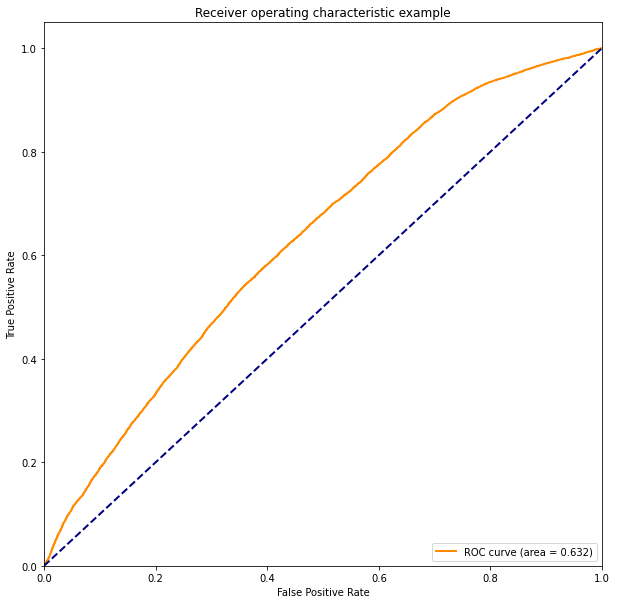

In [62]:
from sklearn.metrics import roc_curve, auc  ###计算roc和auc
import matplotlib.pyplot as plt

def acu_curve(y,prob):
    fpr,tpr,threshold = roc_curve(y,prob) ###计算真正率和假正率
    roc_auc = auc(fpr,tpr) ###计算auc的值
 
    plt.figure()
    lw = 2
    plt.figure(figsize=(10,10))
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.3f)' % roc_auc) ###假正率为横坐标，真正率为纵坐标做曲线
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
 
    plt.show()
    
y_pred = model.predict(X_test)
y_true = np.array(y_val)
#roc_auc_score(y_true, y_pred)
acu_curve(y_true, y_pred)

## Making Predictions for New Data ##

In [63]:
'''
import riiideducation
env = riiideducation.make_env()
iter_test = env.iter_test()
for (test_df, sample_prediction_df) in iter_test:
    test_df['task_container_id'] = test_df.task_container_id.mask(test_df.task_container_id > 9999, 9999)
    test_df = pd.merge(test_df, group3, left_on=['task_container_id'], right_index= True, how="left")
    test_df = pd.merge(test_df, question2, left_on = 'content_id', right_on = 'question_id', how = 'left')
    test_df = pd.merge(test_df, results_u_final, on=['user_id'],  how="left")
    test_df = pd.merge(test_df, results_u2_final, on=['user_id'],  how="left")
    
    test_df = pd.merge(test_df, user_lecture_stats_part, on=['user_id'], how="left")
    test_df['part_1'].fillna(0, inplace = True)
    test_df['part_2'].fillna(0, inplace = True)
    test_df['part_3'].fillna(0, inplace = True)
    test_df['part_4'].fillna(0, inplace = True)
    test_df['part_5'].fillna(0, inplace = True)
    test_df['part_6'].fillna(0, inplace = True)
    test_df['part_7'].fillna(0, inplace = True)
    test_df['type_of_concept'].fillna(0, inplace = True)
    test_df['type_of_intention'].fillna(0, inplace = True)
    test_df['type_of_solving_question'].fillna(0, inplace = True)
    test_df['type_of_starter'].fillna(0, inplace = True)
    test_df['part_1_boolean'].fillna(0, inplace = True)
    test_df['part_2_boolean'].fillna(0, inplace = True)
    test_df['part_3_boolean'].fillna(0, inplace = True)
    test_df['part_4_boolean'].fillna(0, inplace = True)
    test_df['part_5_boolean'].fillna(0, inplace = True)
    test_df['part_6_boolean'].fillna(0, inplace = True)
    test_df['part_7_boolean'].fillna(0, inplace = True)
    test_df['type_of_concept_boolean'].fillna(0, inplace = True)
    test_df['type_of_intention_boolean'].fillna(0, inplace = True)
    test_df['type_of_solving_question_boolean'].fillna(0, inplace = True)
    test_df['type_of_starter_boolean'].fillna(0, inplace = True)
    
    test_df['answered_correctly_user'].fillna(0.65,  inplace=True)
    test_df['explanation_mean_user'].fillna(prior_mean_user,  inplace=True)
    test_df['quest_pct'].fillna(content_mean,  inplace=True)
    test_df['part'] = test_df.part - 1

    test_df['part'].fillna(4, inplace = True)
    test_df['avg_questions_seen'].fillna(1, inplace = True)
    test_df['prior_question_elapsed_time'].fillna(elapsed_mean, inplace = True)
    test_df['prior_question_had_explanation'].fillna(False, inplace=True)
    test_df["prior_question_had_explanation_enc"] = lb_make.fit_transform(test_df["prior_question_had_explanation"])
    X = test_df[['answered_correctly_user', 'explanation_mean_user', 'quest_pct', 'avg_questions_seen',
                                                            'prior_question_elapsed_time','prior_question_had_explanation_enc', 'part',
                                                            'part_1', 'part_2', 'part_3', 'part_4', 'part_5', 'part_6', 'part_7',
                                                            'type_of_concept', 'type_of_intention', 'type_of_solving_question', 'type_of_starter',
                                                            'part_1_boolean', 'part_2_boolean', 'part_3_boolean', 'part_4_boolean', 'part_5_boolean', 'part_6_boolean', 'part_7_boolean',
                                                            'type_of_concept_boolean', 'type_of_intention_boolean', 'type_of_solving_question_boolean', 'type_of_starter_boolean']]
    X=scaler.transform(X)
    X = X.reshape(X.shape[0], X.shape[1], 1)
    X = keras.preprocessing.sequence.pad_sequences(X, maxlen=maxlen)
    test_df['answered_correctly'] =  model.predict(X)

    env.predict(test_df.loc[test_df['content_type_id'] == 0, ['row_id', 'answered_correctly']])
'''

'\nimport riiideducation\nenv = riiideducation.make_env()\niter_test = env.iter_test()\nfor (test_df, sample_prediction_df) in iter_test:\n    test_df[\'task_container_id\'] = test_df.task_container_id.mask(test_df.task_container_id > 9999, 9999)\n    test_df = pd.merge(test_df, group3, left_on=[\'task_container_id\'], right_index= True, how="left")\n    test_df = pd.merge(test_df, question2, left_on = \'content_id\', right_on = \'question_id\', how = \'left\')\n    test_df = pd.merge(test_df, results_u_final, on=[\'user_id\'],  how="left")\n    test_df = pd.merge(test_df, results_u2_final, on=[\'user_id\'],  how="left")\n    \n    test_df = pd.merge(test_df, user_lecture_stats_part, on=[\'user_id\'], how="left")\n    test_df[\'part_1\'].fillna(0, inplace = True)\n    test_df[\'part_2\'].fillna(0, inplace = True)\n    test_df[\'part_3\'].fillna(0, inplace = True)\n    test_df[\'part_4\'].fillna(0, inplace = True)\n    test_df[\'part_5\'].fillna(0, inplace = True)\n    test_df[\'part_6\